In [2]:
import pandas as pd
from pandas import DataFrame as df
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Loading the data

In [3]:
data = pd.read_csv("haberman.csv")
data.head()

,Age,Year_of_op,Nbr_of_nodes,Surv_status
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1


# Preprocessing the data

We preprocess the data same way we did in the project one which consisted the removement of outliers (too high values in Number of node column), balancing the data, normalizing the data, recoding the output variable and dividing the data into training and testing set.

**- Removing the outliers:**

In [4]:
a = data[data["Nbr_of_nodes"] > 30]
print("Observations with too high value in Number of node column:\n", a)

Observations with too high value in Number of node column:
      Age  Year_of_op  Nbr_of_nodes  Surv_status
62    43          58            52            2
174   54          67            46            1
215   59          62            35            2


In [5]:
# removing those three observations:
data = data.drop([62, 174, 215])

**- Recoding the output variable (Survival status):**

In [6]:
data["Surv_status"] = data["Surv_status"].replace([1, 2], [0, 1])

**- Dividing the data into training and testing sets:**

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data.drop(columns=["Surv_status"]), data["Surv_status"],
                                                   test_size=0.3, random_state=50, stratify=data["Surv_status"])
print("Train set size:", x_train.shape)
print("Test set size:", x_test.shape)

Train set size: (212, 3)
Test set size: (91, 3)


In [8]:
print("Train output values:\n" + str(y_train.value_counts()))
print("\nTest output values:\n" + str(y_test.value_counts()))

Train output values:
0    157
1     55
Name: Surv_status, dtype: int64

Test output values:
0    67
1    24
Name: Surv_status, dtype: int64


**- Balancing the data (using SMOTE method):**

In [9]:
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state=5)
x_train, y_train = sm.fit_resample(x_train, y_train)
x_test, y_test = sm.fit_resample(x_test, y_test)
print("Train set output size:\n" + str(y_train.value_counts()))
print("\nTest set output size:\n" + str(y_test.value_counts()))

Train set output size:
0    157
1    157
Name: Surv_status, dtype: int64

Test set output size:
0    67
1    67
Name: Surv_status, dtype: int64


**- Normalizing the data:**

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

# Models

After implementing and analyzing the parametric models (project one) we implement five non-parametric models and analyze their performance. We are going to implement three supervised learning models and two unsupervised learning models, which are K-Nearest Neighbours, Boosted trees, Artificial neural network, K-Means and DBSCAN. K-Means and DBSCAN models are unsupervised learning models.

After implementing the models we will analyze and compare their performance and pick the best one.

# 1. K-NN

We start with K-nearest neighbors classifier which is supervised learning model. The way how the model works is that it classifies the new observation based on the k nearest data points. For example if the k is five and three of the closest data points belongs to class one, the model classifies the new data point belonging to class one. So when we start to implement the model we have to find the optimal value of k. For that we use cross-validation and to score the models with a different k values we use accuracy because it takes into account the both true positive and negative classifications. After finding the optimal k-value we calculate some model evaluation merits.

The optimal k: {'n_neighbors': 1}
The best accuracy score: 0.7391193036354327


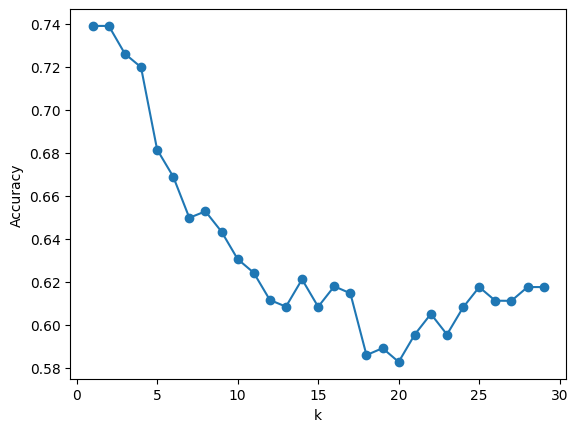

In [15]:
# finding the optimal k
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {"n_neighbors": range(1, 30)}
grid = GridSearchCV(KNeighborsClassifier(), param_grid, scoring="accuracy", cv=5)
grid.fit(x_train, y_train)
print("The optimal k:", grid.best_params_)
print("The best accuracy score:", grid.best_score_)

# plotting the scores
scores = np.array(grid.cv_results_["mean_test_score"])
n_of_k = np.array(param_grid["n_neighbors"])
plt.figure()
plt.plot(n_of_k, scores, "o-")
plt.xlabel("k"); plt.ylabel("Accuracy")
plt.show()

From figure we can see that models with the k one and two got equal and the best accuracy score. Next we try to do cross-validation with three folds to hopefully make our decision easier. 

The optimal k: {'n_neighbors': 2}
The best accuracy score: 0.7452380952380953


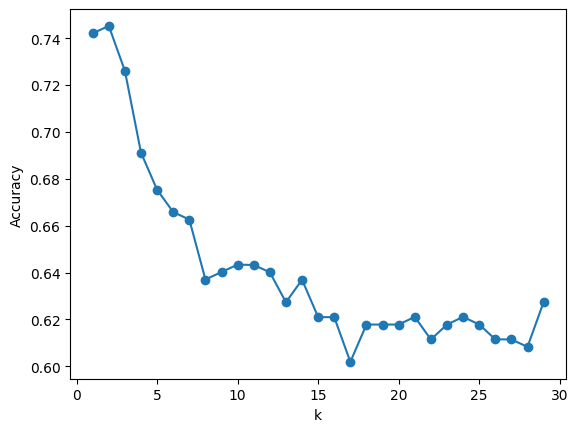

In [16]:
param_grid = {"n_neighbors": range(1, 30)}
grid = GridSearchCV(KNeighborsClassifier(), param_grid, scoring="accuracy", cv=3)
grid.fit(x_train, y_train)
print("The optimal k:", grid.best_params_)
print("The best accuracy score:", grid.best_score_)

# plotting the scores
scores = np.array(grid.cv_results_["mean_test_score"])
n_of_k = np.array(param_grid["n_neighbors"])
plt.figure()
plt.plot(n_of_k, scores, "o-")
plt.xlabel("k"); plt.ylabel("Accuracy")
plt.show()

With three folds we got little bit different result. Because k=2 got the best score in both cross-validtions we pick it to our model.

**K-NN METRICS:**
tn: 59 , fp: 8 , fn: 52 , tp: 15
Accuracy: 0.55
Sensitivity: 0.22
                         precision    recall  f1-score   support

surv. status >= 5 years       0.53      0.88      0.66        67
 surv. status < 5 years       0.65      0.22      0.33        67

               accuracy                           0.55       134
              macro avg       0.59      0.55      0.50       134
           weighted avg       0.59      0.55      0.50       134



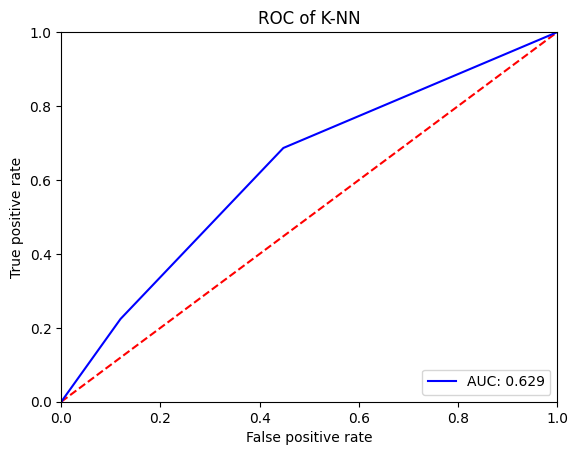

In [21]:
# implementig the model with k=2
knn_model = KNeighborsClassifier(n_neighbors=2).fit(x_train, y_train)
y_pred = knn_model.predict(x_test)
y_pred_prob = knn_model.predict_proba(x_test)

# evaluation metrics
print("**K-NN METRICS:**")
from sklearn.metrics import confusion_matrix
cm_knn = confusion_matrix(y_test, y_pred)

tn_knn, fp_knn, fn_knn, tp_knn = confusion_matrix(y_test, y_pred).ravel()
print("tn:", tn_knn, ",", "fp:", fp_knn, ",", "fn:", fn_knn, ",", "tp:", tp_knn)

# accuracy
from sklearn.metrics import accuracy_score
accuracy_knn = accuracy_score(y_test, y_pred)
print("Accuracy:", round(accuracy_knn, 2))

# sensitivity
from sklearn.metrics import recall_score
sensitivity_knn = recall_score(y_test, y_pred)
print("Sensitivity:", round(sensitivity_knn, 2))

# classification report
from sklearn.metrics import classification_report
names = ["surv. status >= 5 years", "surv. status < 5 years"]
print(classification_report(y_test, y_pred, target_names=names))

# ROC curve and AUC
from sklearn.metrics import roc_curve, auc
fpr_knn, tpr_knn, treshold_knn = roc_curve(y_test, y_pred_prob[:,1])
auc_knn = auc(fpr_knn, tpr_knn)

# plotting
import matplotlib.pyplot as plt
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr_knn, tpr_knn, "b", label="AUC: "+str(round(auc_knn, 3)))
plt.legend(loc='lower right')
plt.xlim([0, 1]), plt.ylim([0, 1])
plt.title("ROC of K-NN")
plt.xlabel("False positive rate"), plt.ylabel("True positive rate")
plt.show()

From the evaluation metircs we can see that the model didn't perform so well because the accuracy (the 

# 2. Gradient boosting trees

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
mode = GradientBoostingClassifier(random_state=5)
